# Importing Libraries

In [38]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
!pip install xgboost --quiet
import xgboost as xgb
from sklearn.metrics import f1_score, log_loss, confusion_matrix
!pip install tensorflow --quiet
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
!pip install transformers --quiet
!pip install datasets --quiet
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
!pip install keras-tuner --quiet
import keras_tuner as kt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

## Dataset Review

In [2]:
pd.set_option('display.max_colwidth', None)
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final project/quora_question_pairs_train.csv.zip")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final project/quora_question_pairs_test.csv.zip")
train_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
1,196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
3,266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1
5,250052,363829,363830,I got a seat in engineering management in Kettering University. Is that good to go? Will that build my career? What opportunities will I have after doing that course?,I am a petroleum engineer. Got an offer from Scotland University for energy economics course. Should I go there? What are the job opportunities?,0
6,302372,425388,425389,Why do people avoid south facing homes?,"Why is a ""south facing"" home so important to some people?",0
7,168009,260327,260328,What is the best site to watch the Turkish drama Ask Laftan Anlamaz with English subtitles?,Is there a way that I can watch Kucuk Gelin (The Child Bride)-(a turkish drama) with english subtitles from seasons 2 till the last season?,0
8,402631,176809,185587,What is the best small business to start in Nagpur?,Which business/startup should I start in Nagpur which will have best chances of survival?,1
9,173627,267799,28951,"I was born to Indian parents in USA. I came back to India at the age of 1 without an American passport, on my mother's passport. What is the procedure to claim US citizenship by right of birth?",Which countries do you automatically get a passport and citizenship if you are born there (regardless of nationality of child's parents)?,0


In [3]:
test_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,305985,429434,429435,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
1,5193,10230,10231,At what valuation did Homejoy raise money in December of 2013?,"Should a wealthy founder self-fund his second startup then raise money at high valuation after getting traction, or raise money at low valuation before any traction?",0
2,123326,199422,199423,How do we judge?,How do I judge my love?,0
3,368557,327674,498931,Are Adderall and meth the same?,Are concerta and meth test the same?,0
4,369226,499645,499646,"If you had internet access to only one site for the rest of your life, which site would you pick?",Why is there .co.uk for British internet sites but only .fr for French ones?,0
5,187677,285991,285992,What is the best ringtone song ever?,What are the most soothing songs that you have ever heard?,0
6,259286,375033,375034,How can I use call forwarding with T-Mobile?,How do you use Call Forwarding with AT&T?,0
7,166610,258484,258485,How do I remember study points?,How can I remember studying points?,1
8,34868,63818,63819,How many hours have you spend on Quora?,How many hours a day do you spend on Quora?,1
9,335103,462362,462363,Short story on pride and ego?,How would I know if lets say New York was nuked yesterday and I live in Canada? Will the skies all over NA be red?,0


In [4]:
train_df.shape

(323432, 6)

In [5]:
test_df.shape

(80858, 6)

In [6]:
train_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323432 entries, 0 to 323431
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            323432 non-null  int64 
 1   qid1          323432 non-null  int64 
 2   qid2          323432 non-null  int64 
 3   question1     323431 non-null  object
 4   question2     323430 non-null  object
 5   is_duplicate  323432 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.8+ MB


In [7]:
test_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80858 entries, 0 to 80857
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            80858 non-null  int64 
 1   qid1          80858 non-null  int64 
 2   qid2          80858 non-null  int64 
 3   question1     80858 non-null  object
 4   question2     80858 non-null  object
 5   is_duplicate  80858 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.7+ MB


The train dataset has 323,432 records. There is only 1 null value in the "question1" column and 2 null values in the column "question2", therefore, we can drop these rows from the dataset - it will not impact the quality of the model.  
The test dataset has 80,858 records, there are no nulls.

## Removing Missing Values

In [8]:
train_df = train_df.dropna(subset=['question1', 'question2'])
train_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 0 to 323431
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            323429 non-null  int64 
 1   qid1          323429 non-null  int64 
 2   qid2          323429 non-null  int64 
 3   question1     323429 non-null  object
 4   question2     323429 non-null  object
 5   is_duplicate  323429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 17.3+ MB


In [9]:
train_df[(train_df['question1'].str.strip() == '') | (train_df['question2'].str.strip() == '')]

,id,qid1,qid2,question1,question2,is_duplicate


In [10]:
test_df[(test_df['question1'].str.strip() == '') | (test_df['question2'].str.strip() == '')]

,id,qid1,qid2,question1,question2,is_duplicate


There are no records with empty strings, so we've deleted all the empty values

## Distribution of the Target Metric (is_duplicate)

In [11]:
train_df['is_duplicate'].value_counts()

,count
is_duplicate,
0,204019
1,119410


In [12]:
test_df['is_duplicate'].value_counts()

,count
is_duplicate,
0,51005
1,29853


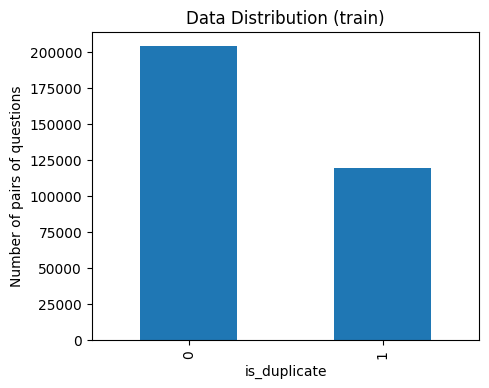

In [13]:
train_df['is_duplicate'].value_counts().plot(
    kind='bar',
    figsize=(5, 4),
    title='Data Distribution (train)'
)
plt.xlabel('is_duplicate')
plt.ylabel('Number of pairs of questions')
plt.show()

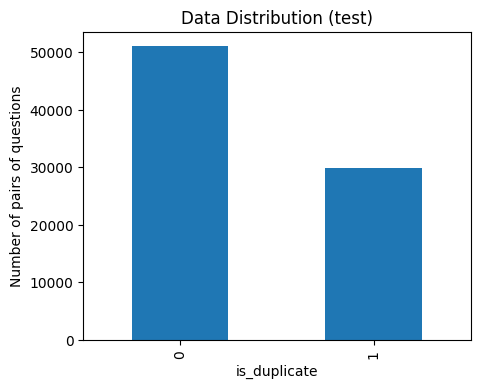

In [14]:
test_df['is_duplicate'].value_counts().plot(
    kind='bar',
    figsize=(5, 4),
    title='Data Distribution (test)'
)
plt.xlabel('is_duplicate')
plt.ylabel('Number of pairs of questions')
plt.show()

There are 204,019 non-duplicates and 119,410 duplicates in the train dataset (test: 51,005 and 29,853, respectively)

## Text Length

In [15]:
train_df['len_chars_q1'] = train_df['question1'].str.len()
train_df['len_chars_q2'] = train_df['question2'].str.len()
train_df['len_words_q1'] = train_df['question1'].str.split().apply(len)
train_df['len_words_q2'] = train_df['question2'].str.split().apply(len)
train_df[['len_chars_q1', 'len_chars_q2', 'len_words_q1', 'len_words_q2']].describe()

,len_chars_q1,len_chars_q2,len_words_q1,len_words_q2
count,323429.000000,323429.000000,323429.000000,323429.000000
mean,59.531761,60.123242,10.941715,11.184554
std,29.921286,33.889595,5.426282,6.312174
min,1.000000,1.000000,1.000000,1.000000
25%,39.000000,39.000000,7.000000,7.000000
50%,52.000000,51.000000,10.000000,10.000000
75%,72.000000,72.000000,13.000000,13.000000
max,623.000000,1169.000000,125.000000,237.000000


In [16]:
test_df['len_chars_q1'] = test_df['question1'].str.len()
test_df['len_chars_q2'] = test_df['question2'].str.len()
test_df['len_words_q1'] = test_df['question1'].str.split().apply(len)
test_df['len_words_q2'] = test_df['question2'].str.split().apply(len)
test_df[['len_chars_q1', 'len_chars_q2', 'len_words_q1', 'len_words_q2']].describe()

,len_chars_q1,len_chars_q2,len_words_q1,len_words_q2
count,80858.000000,80858.000000,80858.000000,80858.000000
mean,59.557941,60.049568,10.944421,11.171869
std,30.017671,33.759501,5.438952,6.277303
min,1.000000,1.000000,1.000000,1.000000
25%,39.000000,39.000000,7.000000,7.000000
50%,52.000000,51.000000,10.000000,10.000000
75%,72.000000,71.000000,13.000000,13.000000
max,343.000000,1169.000000,73.000000,237.000000


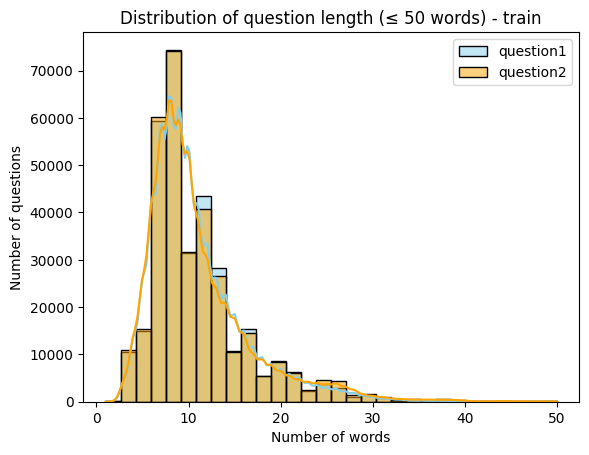

In [17]:
subset_df = train_df[
    (train_df['len_words_q1'] <= 50) &
    (train_df['len_words_q2'] <= 50)
]
sns.histplot(subset_df['len_words_q1'], bins=30, color='skyblue', label='question1', kde=True)
sns.histplot(subset_df['len_words_q2'], bins=30, color='orange', label='question2', kde=True)
plt.legend()
plt.title('Distribution of question length (≤ 50 words) - train')
plt.xlabel('Number of words')
plt.ylabel('Number of questions')
plt.show()

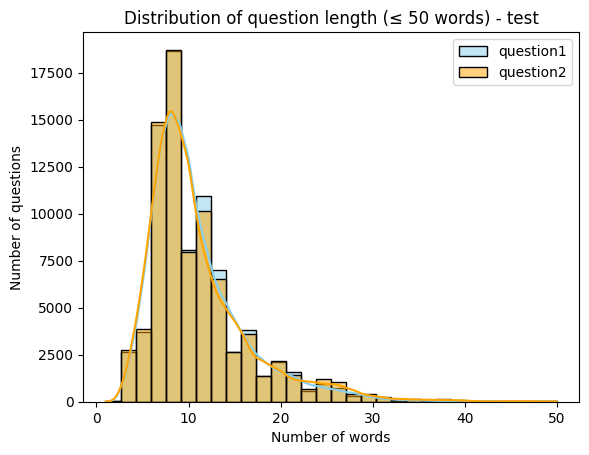

In [18]:
subset_df_test = test_df[
    (test_df['len_words_q1'] <= 50) &
    (test_df['len_words_q2'] <= 50)
]
sns.histplot(subset_df_test['len_words_q1'], bins=30, color='skyblue', label='question1', kde=True)
sns.histplot(subset_df_test['len_words_q2'], bins=30, color='orange', label='question2', kde=True)
plt.legend()
plt.title('Distribution of question length (≤ 50 words) - test')
plt.xlabel('Number of words')
plt.ylabel('Number of questions')
plt.show()

In [19]:
all_questions_train = pd.concat([train_df['question1'], train_df['question2']], ignore_index=True)
unique_words_train = set(' '.join(all_questions_train.dropna().str.lower()).split())
len(unique_words_train)

178367

In [20]:
all_questions_test = pd.concat([test_df['question1'], test_df['question2']], ignore_index=True)
unique_words_test = set(' '.join(all_questions_test.dropna().str.lower()).split())
len(unique_words_test)

82575

## The Most Frequently Used Words

In [21]:
word_counts_train = Counter(' '.join(all_questions_train.dropna().str.lower()).split())
common_words_train = word_counts_train.most_common(20)
pd.DataFrame(common_words_train, columns=['word', 'count'])

,word,count
0,the,301023
1,what,248836
2,is,214821
3,how,175295
4,i,170695
5,a,168388
6,to,163514
7,in,155567
8,of,127084
9,do,123789


In [22]:
word_counts_test = Counter(' '.join(all_questions_test.dropna().str.lower()).split())
common_words_test = word_counts_test.most_common(20)
pd.DataFrame(common_words_test, columns=['word', 'count'])

,word,count
0,the,75210
1,what,62126
2,is,54026
3,how,43722
4,i,42488
5,a,41845
6,to,40553
7,in,39157
8,of,31827
9,do,30931


Furthermore, we can check the correlation of the difference in question1-question2 length vs. probability of duplicate:

In [23]:
train_df['len_q1'] = train_df['question1'].str.len()
train_df['len_q2'] = train_df['question2'].str.len()
train_df['len_diff'] = (train_df['len_q1'] - train_df['len_q2']).abs()
train_df[['len_q1', 'len_q2', 'len_diff']].describe()


,len_q1,len_q2,len_diff
count,323429.000000,323429.000000,323429.000000
mean,59.531761,60.123242,20.158248
std,29.921286,33.889595,25.605567
min,1.000000,1.000000,0.000000
25%,39.000000,39.000000,4.000000
50%,52.000000,51.000000,12.000000
75%,72.000000,72.000000,26.000000
max,623.000000,1169.000000,1080.000000


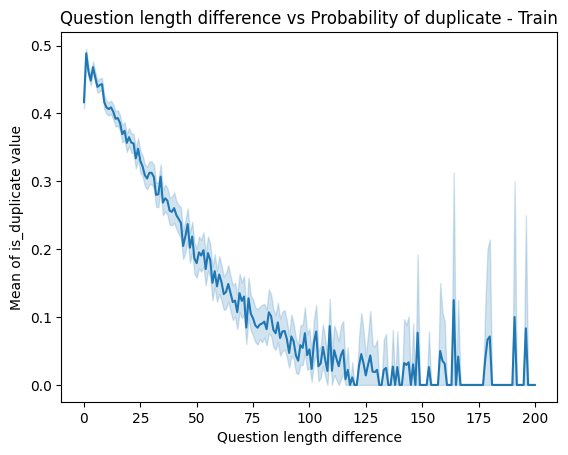

In [24]:
subset_df = train_df[train_df['len_diff'] <= 200]
sns.lineplot(
    data=subset_df,
    x='len_diff',
    y='is_duplicate',
)
plt.title('Question length difference vs Probability of duplicate - Train')
plt.xlabel('Question length difference')
plt.ylabel('Mean of is_duplicate value')
plt.show()


In [25]:
test_df['len_q1'] = test_df['question1'].str.len()
test_df['len_q2'] = test_df['question2'].str.len()
test_df['len_diff'] = (test_df['len_q1'] - test_df['len_q2']).abs()
test_df[['len_q1', 'len_q2', 'len_diff']].describe()

,len_q1,len_q2,len_diff
count,80858.000000,80858.000000,80858.000000
mean,59.557941,60.049568,20.156472
std,30.017671,33.759501,25.497749
min,1.000000,1.000000,0.000000
25%,39.000000,39.000000,5.000000
50%,52.000000,51.000000,12.000000
75%,72.000000,71.000000,26.000000
max,343.000000,1169.000000,1038.000000


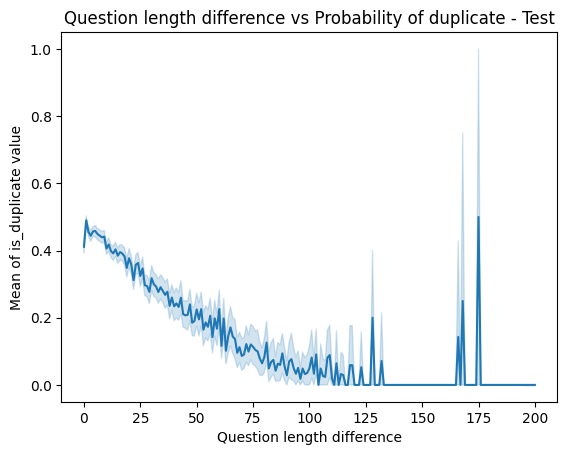

In [26]:
subset_df_test = test_df[test_df['len_diff'] <= 200]
sns.lineplot(
    data=subset_df_test,
    x='len_diff',
    y='is_duplicate',
)
plt.title('Question length difference vs Probability of duplicate - Test')
plt.xlabel('Question length difference')
plt.ylabel('Mean of is_duplicate value')
plt.show()


In general, it can be seen that the greater the difference in the length of the questions, the less likely they are to be duplicates. But of course there are exceptions, because there are questions that can be formulated much more compactly and then the difference in length will be large, but it will be the same question.

# Text Preprocessing

In [27]:
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

def preprocess_text_safe(text):
    if pd.isna(text):
        return []
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = text.lower().split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    stems = [stemmer.stem(w) for w in tokens]
    return stems

vectorizer = CountVectorizer(tokenizer=preprocess_text_safe, lowercase=True, max_features=1000, token_pattern=None)

X1_train = vectorizer.fit_transform(train_df['question1'].fillna(''))
X2_train = vectorizer.transform(train_df['question2'].fillna(''))
cos_sim_train = np.array([cosine_similarity(X1_train[i], X2_train[i])[0][0] for i in range(X1_train.shape[0])]).reshape(-1,1)
X_train_combined = hstack([X1_train, X2_train, cos_sim_train])
y_train = train_df['is_duplicate']

X1_test = vectorizer.transform(test_df['question1'].fillna(''))
X2_test = vectorizer.transform(test_df['question2'].fillna(''))
cos_sim_test = np.array([cosine_similarity(X1_test[i], X2_test[i])[0][0] for i in range(X1_test.shape[0])]).reshape(-1,1)
X_test_combined = hstack([X1_test, X2_test, cos_sim_test])
y_test = test_df['is_duplicate']


# Modeling

## Logistic Regression

In [28]:
param_dist_logreg = {
    'C': np.logspace(-2, 2, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

random_logreg = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    param_distributions=param_dist_logreg,
    n_iter=10,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

random_logreg.fit(X_train_combined, y_train)
model_log_reg = random_logreg.best_estimator_

y_train_proba = model_log_reg.predict_proba(X_train_combined)[:, 1]
y_train_pred = model_log_reg.predict(X_train_combined)

logloss_train = log_loss(y_train, y_train_proba)
f1_train = f1_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

y_test_proba = model_log_reg.predict_proba(X_test_combined)[:, 1]
y_test_pred = model_log_reg.predict(X_test_combined)

logloss_test = log_loss(y_test, y_test_proba)
f1_test = f1_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("== Train Metrics ==")
print(f"Log loss (train): {logloss_train:.4f}")
print(f"F1-score (train): {f1_train:.4f}")
print("Confusion Matrix (train):")
print(cm_train)

print("\n== Test Metrics ==")
print(f"Log loss (test): {logloss_test:.4f}")
print(f"F1-score (test): {f1_test:.4f}")
print("Confusion Matrix (test):")
print(cm_test)

print("\nBest parameters found:")
print(random_logreg.best_params_)


== Train Metrics ==
Log loss (train): 0.5118
F1-score (train): 0.6177
Confusion Matrix (train):
[[169391  34628]
 [ 50569  68841]]

== Test Metrics ==
Log loss (test): 0.5173
F1-score (test): 0.6149
Confusion Matrix (test):
[[42195  8810]
 [12688 17165]]

Best parameters found:
{'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(37.92690190732246)}


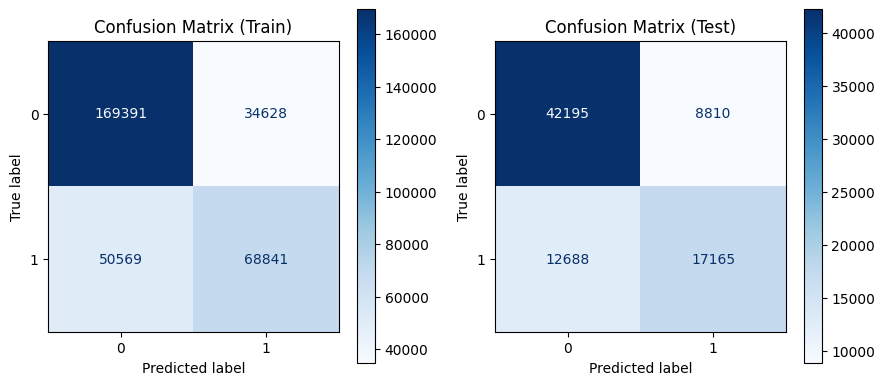

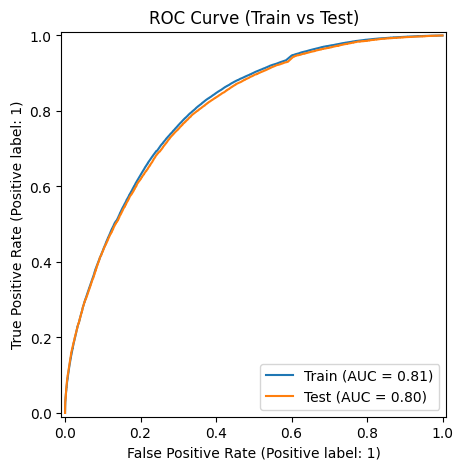

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_estimator(model_log_reg, X_train_combined, y_train, cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_estimator(model_log_reg, X_test_combined, y_test, cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(model_log_reg, X_train_combined, y_train, ax=ax, name="Train")
RocCurveDisplay.from_estimator(model_log_reg, X_test_combined, y_test, ax=ax, name="Test")
plt.title("ROC Curve (Train vs Test)")
plt.show()

## XGBoost

In [34]:
X_train_dense = X_train_combined
X_test_dense = X_test_combined

model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_log_loss',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_dense, y_train)

best_model = random_search.best_estimator_

y_train_pred_proba = best_model.predict_proba(X_train_dense)[:, 1]
y_train_pred = best_model.predict(X_train_dense)

logloss_train = log_loss(y_train, y_train_pred_proba)
f1_train = f1_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

print("Train Metrics:")
print(f"Log loss: {logloss_train:.4f}")
print(f"F1-score: {f1_train:.4f}")
print("Confusion Matrix:")
print(cm_train)

y_test_pred_proba = best_model.predict_proba(X_test_dense)[:, 1]
y_test_pred = best_model.predict(X_test_dense)

logloss_test = log_loss(y_test, y_test_pred_proba)
f1_test = f1_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"Log loss: {logloss_test:.4f}")
print(f"F1-score: {f1_test:.4f}")
print("Confusion Matrix:")
print(cm_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:03:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Metrics:
Log loss: 0.5098
F1-score: 0.6258
Confusion Matrix:
[[170699  33320]
 [ 49864  69546]]

Test Metrics:
Log loss: 0.5159
F1-score: 0.6175
Confusion Matrix:
[[42410  8595]
 [12681 17172]]


In [35]:
print(random_search.best_params_)

{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


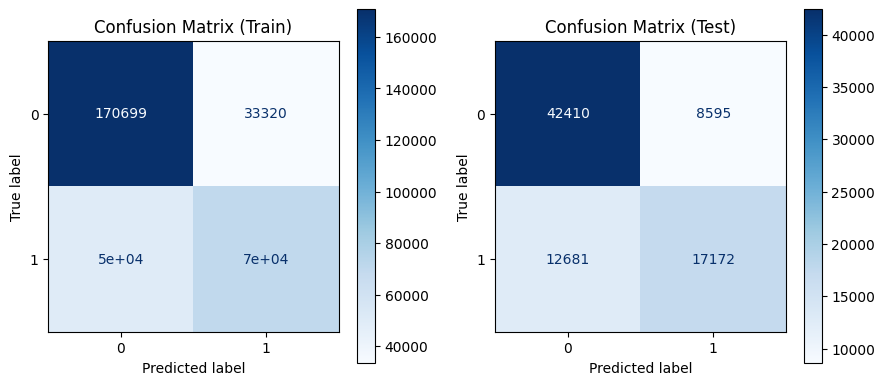

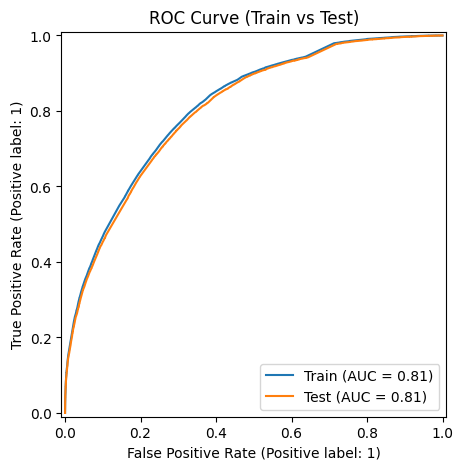

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_estimator(best_model, X_train_combined, y_train, cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_estimator(best_model, X_test_combined, y_test, cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_model, X_train_combined, y_train, ax=ax, name="Train")
RocCurveDisplay.from_estimator(best_model, X_test_combined, y_test, ax=ax, name="Test")
plt.title("ROC Curve (Train vs Test)")
plt.show()

## LSTM

In [39]:
all_texts = pd.concat([train_df['question1'], train_df['question2']]).fillna('').tolist()

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)

q1_seq_train = pad_sequences(tokenizer.texts_to_sequences(train_df['question1'].fillna('')), maxlen=50)
q2_seq_train = pad_sequences(tokenizer.texts_to_sequences(train_df['question2'].fillna('')), maxlen=50)

q1_seq_test = pad_sequences(tokenizer.texts_to_sequences(test_df['question1'].fillna('')), maxlen=50)
q2_seq_test = pad_sequences(tokenizer.texts_to_sequences(test_df['question2'].fillna('')), maxlen=50)

def build_model(hp):
    input_q1 = Input(shape=(50,))
    input_q2 = Input(shape=(50,))

    embedding_dim = hp.Choice('embedding_dim', [50, 100])
    lstm_units = hp.Choice('lstm_units', [32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    lr = hp.Choice('learning_rate', [1e-3, 1e-4])

    embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=50)

    x1 = embedding_layer(input_q1)
    x1 = Bidirectional(LSTM(lstm_units))(x1)

    x2 = embedding_layer(input_q2)
    x2 = Bidirectional(LSTM(lstm_units))(x2)

    merged = concatenate([x1, x2])
    merged = Dropout(dropout_rate)(merged)
    output = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[input_q1, input_q2], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tuning',
    overwrite=True
)

tuner.search([q1_seq_train, q2_seq_train], y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

y_train_pred_proba = best_model.predict([q1_seq_train, q2_seq_train], batch_size=128).ravel()
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

logloss_train = log_loss(y_train, y_train_pred_proba)
f1_train = f1_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

print("Train Metrics:")
print(f"Log loss: {logloss_train:.4f}")
print(f"F1-score: {f1_train:.4f}")
print("Confusion Matrix:")
print(cm_train)

y_test_pred_proba = best_model.predict([q1_seq_test, q2_seq_test], batch_size=128).ravel()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

logloss_test = log_loss(y_test, y_test_pred_proba)
f1_test = f1_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"Log loss: {logloss_test:.4f}")
print(f"F1-score: {f1_test:.4f}")
print("Confusion Matrix:")
print(cm_test)

print("\nBest Hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)


Trial 5 Complete [00h 42m 28s]
val_loss: 0.5018044710159302

Best val_loss So Far: 0.4911556839942932
Total elapsed time: 02h 36m 08s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2527/2527 ━━━━━━━━━━━━━━━━━━━━ 107s 42ms/step
Train Metrics:
Log loss: 0.4383
F1-score: 0.7038
Confusion Matrix:
[[178542  25477]
 [ 40738  78672]]
632/632 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step

Test Metrics:
Log loss: 0.4869
F1-score: 0.6615
Confusion Matrix:
[[43512  7493]
 [11396 18457]]

Best Hyperparameters:
{'embedding_dim': 50, 'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001}


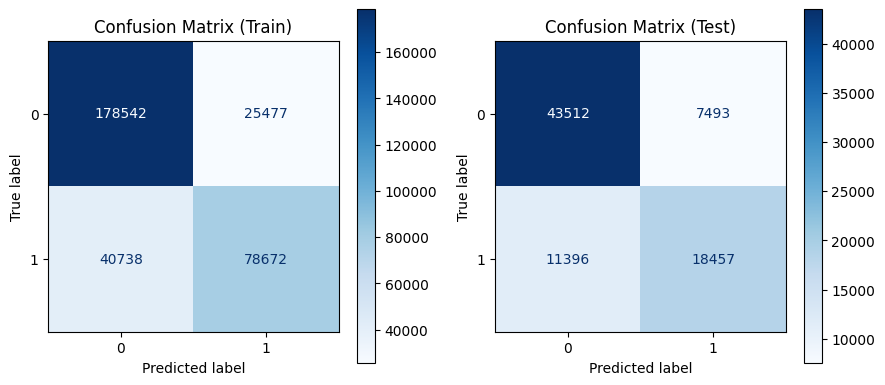

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

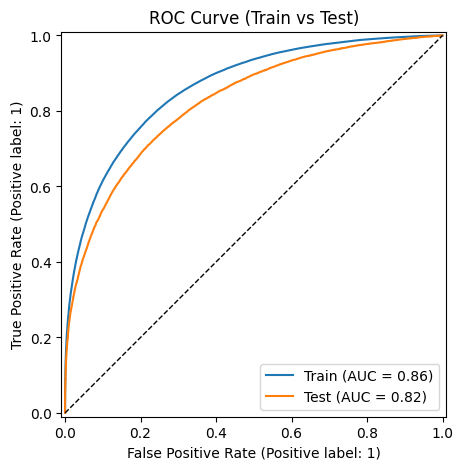

In [42]:
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(
    y_train,
    y_train_pred_proba,
    ax=ax,
    name="Train"
)
RocCurveDisplay.from_predictions(
    y_test,
    y_test_pred_proba,
    ax=ax,
    name="Test"
)
plt.title("ROC Curve (Train vs Test)")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.legend()
plt.show()

The LSTM model achieved the best performance, with the lowest test log loss (0.4869).  

In [44]:
!pip freeze > requirements.txt
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>